# Access SMAP dataset from the AWS Cloud

### Choose a target region and time period, cycle through all available high-resolution SSS, identify clear images, catalog them 

https://github.com/NASA-Openscapes/nch2021-projects-contexdata

- This builds on biavillasboas's notebook
- We will use L3 RSS SMAP here, PO.DAAC short name "SMAP_RSS_L3_SSS_SMI_8DAY-RUNNINGMEAN_V5"


Issues/to-do:

1. Lets code and see what we get


## Summary of what I learned 

1. Cloud computing is just using someone else’s computer.
1. The place where there is an advantage to be had is when you can do cloud computing next to a huge amount of data
1. If you must work locally, or on a different cloud than where the data are, data sets in the cloud are functionally just data sets on the web
1. We can query the NASA Common Metadata Repository to find out the names and “concept ID” of datasets (url = 'https://cmr.earthdata.nasa.gov/search/collections.umm_json'); see example below in this notebook
1. To download data (to cloud or local machine), you need a _netrc file (on windows) or .netrc file (on linux) to pass NASA EarthData credentials and get S3 access;—see Tutorial 4, https://github.com/NASA-Openscapes/2021-Cloud-Hackathon/blob/main/tutorials/04_NASA_Earthdata_Authentication.ipynb ; this is needed in “def begin_s3_direct_access()” below; for direct download, it would also be needed
1. We were working in the Amazon Cloud using the “2i2c Hub Service”:
https://openscapes.2i2c.cloud/hub/login?next=%2Fhub%2F


In [1]:
#!conda install -y -c conda-forge s3fs numpy pandas xarray matplotlib cartopy ipympl ipywidgets h5netcdf dask netCDF4 bottleneck

In [2]:
#!conda install -y -c conda-forge cartopy=0.21

In [1]:
#Pretty sure some of these are extraneous
import s3fs
import os
import os.path
import json
import warnings
import requests
import numpy as np
import pandas as pd
import xarray as xr
from io import StringIO

import matplotlib.pyplot as plt
import matplotlib
from matplotlib.ticker import FormatStrFormatter
from matplotlib import ticker, rc, cm

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy

# import geoviews as gv
# import hvplot.xarray
# import holoviews as hv
# gv.extension('bokeh', 'matplotlib')

warnings.filterwarnings("ignore")

# %matplotlib inline
# %matplotlib qt5
%matplotlib widget

## Set some parameters (start/end time)


In [2]:
plt.rcParams['figure.figsize'] = (5,4)
plt.rcParams['figure.dpi'] = 150
plt.rcParams['savefig.dpi'] = 150

savefig = False # set to true to save plots as file
!mkdir ../plots
__figdir__ = '../plots/'
savefig_args = {'bbox_inches':'tight', 'pad_inches':0.2}
plotfiletype='png'

mkdir: cannot create directory ‘../plots’: File exists


## PO DAAC Catalog exploration using the CMR API

- The search is restricted to colections that have data over a given time window

In [3]:
provider = 'POCLOUD'
url = 'https://cmr.earthdata.nasa.gov/search/collections.umm_json'
response = requests.get(url,
                        params={
                            'cloud_hosted': 'True',
                            'has_granules': 'True',
                            'provider': provider,
                            'page_size': 500,
                            'temporal': ['2021-10-01T10:00:00Z','2021-11-01T00:00:00Z'] 
                        },
                        headers={
                            'Accept': 'application/json'
                        }
                       )
response.headers['cmr-hits']

'241'

### Loop through each response in the catalog and print the respective concept ID

These are the data sets that cover the time period of interest

In [5]:
#  This will show short names and concept ids for all PO.DAAC data sets at this time
if True:
    for r in response.json()['items']:
        print('{} ==> '.format(r['meta']['s3-links'][0].split('/')[1]), r['meta']['concept-id'])

MODIS_A-JPL-L2P-v2019.0 ==>  C1940473819-POCLOUD
CYGNSS_L1_V3.1 ==>  C2146321631-POCLOUD
ASCATB-L2-25km ==>  C2075141559-POCLOUD
MODIS_T-JPL-L2P-v2019.0 ==>  C1940475563-POCLOUD
VIIRS_N20-STAR-L2P-v2.80 ==>  C2147478146-POCLOUD
ASCATC-L2-25km ==>  C2075141638-POCLOUD
CMC0.1deg-CMC-L4-GLOB-v3.0 ==>  C2036881720-POCLOUD
MUR-JPL-L4-GLOB-v4.1 ==>  C1996881146-POCLOUD
VIIRS_NPP-STAR-L2P-v2.80 ==>  C2147480877-POCLOUD
AVHRRF_MB-STAR-L3U-v2.80 ==>  C2205121416-POCLOUD
CYGNSS_L1_V2.1 ==>  C2251464384-POCLOUD
VIIRS_NPP-NAVO-L2P-v3.0 ==>  C1996881636-POCLOUD
ASCATB-L2-Coastal ==>  C2075141605-POCLOUD
ASCATC-L2-Coastal ==>  C2075141684-POCLOUD
JASON_CS_S6A_L2_ALT_HR_STD_OST_NRT_F ==>  C1968979566-POCLOUD
JASON_CS_S6A_L2_ALT_LR_STD_OST_NRT_F ==>  C1968979597-POCLOUD
VIIRS_N20-STAR-L3U-v2.80 ==>  C2147488020-POCLOUD
VIIRS_NPP-STAR-L3U-v2.80 ==>  C2147485059-POCLOUD
AVHRRF_MC-STAR-L3U-v2.80 ==>  C2205121433-POCLOUD
AVHRR_SST_METOP_B-OSISAF-L2P-v1.0 ==>  C2036880717-POCLOUD
JASON_CS_S6A_L2_ALT_LR_STD

### Loading credentials for direct access

In [6]:
def begin_s3_direct_access(url: str="https://archive.podaac.earthdata.nasa.gov/s3credentials"):
    response = requests.get(url).json()
    return s3fs.S3FileSystem(key=response['accessKeyId'],
                             secret=response['secretAccessKey'],
                             token=response['sessionToken'],
                             client_kwargs={'region_name':'us-west-2'})

fs = begin_s3_direct_access()

type(fs)

s3fs.core.S3FileSystem

In [56]:
# Center location
#site = 'S-MODE'
site = 'Arabian Sea'
#site = 'SPURS-1'

if site == 'S-MODE':
    lon0 = -123.5
    lat0 = 37.5 
    dlon = 2.5 # half of box width in lon
    dlat = 1.5 # half of box width in lat
elif site == 'S-MODE IOP1':
    lon0 = -124.5
    lat0 = 37
    dlon = 2.5 # half of box width in lon
    dlat = 1.5 # half of box width in lat
elif site == 'SPURS-2':
    lon0 = -125
    lat0 = 10
    dlon = 1.5 # half of box width in lon
    dlat = 1.5 # half of box width in lat
elif site == 'SPURS-1':
    lon0 = -38
    lat0 = 25
    dlon = 1.5 # half of box width in lon
    dlat = 1.5 # half of box width in lat
elif site == 'Arabian Sea':
    lon0 = 65
    lat0 = 15
    dlon = 10 # half of box width in lon
    dlat = 10 # half of box width in lat
# Define the max/min lon
lon_min = lon0 - dlon
lon_max = lon0 + dlon
lat_min = lat0 - dlat
lat_max = lat0 + dlat

In [8]:
if site == 'S-MODE':
    start_time = '2021-10-20T00:00:00Z'
    end_time = '2021-11-6T00:00:00Z'
elif site == 'S-MODE IOP1':
    start_time = '2022-10-01T00:00:00Z'#
    end_time = '2022-11-6T00:00:00Z'
elif site == 'SPURS-2':
    start_time = '2017-1-05T00:00:00Z'#'2016-8-20T00:00:00Z'
    end_time = '2017-11-6T00:00:00Z'
elif site == 'SPURS-1':
    start_time = '2012-12-15T00:00:00Z'#'2012-9-15T00:00:00Z'
    end_time = '2013-11-15T00:00:00Z'
elif site == 'Arabian Sea':
    start_time = '2018-02-15T00:00:00Z'#'2012-9-15T00:00:00Z'
    end_time = '2018-03-15T00:00:00Z'


Maybe try these:

https://podaac.jpl.nasa.gov/dataset/VIIRS_NPP-STAR-L3U-v2.80  
'C2147485059-POCLOUD' #VIIRS_NPP-STAR-L3U-v2.80

https://podaac.jpl.nasa.gov/dataset/VIIRS_N20-STAR-L3U-v2.80  
'C2147488020-POCLOUD' #VIIRS_N20-STAR-L3U-v2.80

In [15]:
url = 'https://cmr.earthdata.nasa.gov/search/granules'

# VIIRS_NPP-OSPO-L2P-v2.61 ==>  C1996880725-POCLOUD
concept_id = 'C2208425700-POCLOUD';shortname= 'SMAP_RSS_L3_SSS_SMI_8DAY-RUNNINGMEAN_V5' #  SMAP_RSS_8dayrunningmean_V5
#concept_id = 'C2147478146-POCLOUD' #'C1996880725-POCLOUD' # VIIRS_NPP-OSPO-L2P-v2.61 
# concept_id = 'C2036877595-POCLOUD' # VIIRS_NPP-OSPO-L3U-v2.61 
#concept_id = 'C2147488020-POCLOUD'; shortname= 'VIIRS_N20-STAR-L3U-v2.80'
#concept_id = 'C2147485059-POCLOUD'; shortname= 'VIIRS_NPP-STAR-L3U-v2.80'
response = requests.get(url, 
                        params={
                            'concept_id': concept_id,
                            'temporal': start_time+','+end_time,
                            'bounding_box': '{},{},{},{}'.format(lon_min, lat_min, lon_max, lat_max),    
                            'page_size': 500,
                            },
                        headers={
                            'Accept': 'application/json'
                            }
                       )
print(response)
print(response.headers['CMR-Hits'])

<Response [200]>
36


In [16]:
granules_url = []
for gran in response.json()['feed']['entry']:
    granules_url.append(gran['links'][1]['href'])
# granules_url
len(granules_url)
print('Number of files found is ' + str(len(granules_url)))
if len(granules_url) == 500:
    print('Max number of files returned. There may be more files.  Try shortening time window.')

Number of files found is 36


In [19]:
gran['links'];#['rel'=='http://esipfed.org/ns/fedsearch/1.1/s3#'];

In [18]:
granules_url

['s3://podaac-ops-cumulus-protected/SMAP_RSS_L3_SSS_SMI_8DAY-RUNNINGMEAN_V5/RSS_smap_SSS_L3_8day_running_2018_042_FNL_v05.0.nc',
 's3://podaac-ops-cumulus-public/SMAP_RSS_L3_SSS_SMI_8DAY-RUNNINGMEAN_V5/RSS_smap_SSS_L3_8day_running_2018_043_FNL_v05.0.nc.md5',
 's3://podaac-ops-cumulus-protected/SMAP_RSS_L3_SSS_SMI_8DAY-RUNNINGMEAN_V5/RSS_smap_SSS_L3_8day_running_2018_044_FNL_v05.0.nc',
 's3://podaac-ops-cumulus-public/SMAP_RSS_L3_SSS_SMI_8DAY-RUNNINGMEAN_V5/RSS_smap_SSS_L3_8day_running_2018_045_FNL_v05.0.nc.md5',
 's3://podaac-ops-cumulus-protected/SMAP_RSS_L3_SSS_SMI_8DAY-RUNNINGMEAN_V5/RSS_smap_SSS_L3_8day_running_2018_046_FNL_v05.0.nc',
 's3://podaac-ops-cumulus-public/SMAP_RSS_L3_SSS_SMI_8DAY-RUNNINGMEAN_V5/RSS_smap_SSS_L3_8day_running_2018_047_FNL_v05.0.nc.md5',
 's3://podaac-ops-cumulus-protected/SMAP_RSS_L3_SSS_SMI_8DAY-RUNNINGMEAN_V5/RSS_smap_SSS_L3_8day_running_2018_048_FNL_v05.0.nc',
 's3://podaac-ops-cumulus-protected/SMAP_RSS_L3_SSS_SMI_8DAY-RUNNINGMEAN_V5/RSS_smap_SSS_L3_8d

## There is an inconvenient issue with these files.  The correct link is not in the same place for each of the granules

This was an attempt to fix the issue by just dropping the md5 suffix.  That almost works, but the prefix should be something like:  
s3://podaac-ops-cumulus-protected/ 

and not:  
s3://podaac-ops-cumulus-public/

In [20]:
granules_url2 = []
for gran in granules_url:
    #print(gran.replace('.md5',''))
    gran2 = gran.replace('.md5','')
    #print(gran2[gran2.index('/VIIRS'):])
    granules_url2.append('s3://podaac-ops-cumulus-protected'+gran2[gran2.index('/SMAP_RSS'):])


In [21]:
granules_url2

['s3://podaac-ops-cumulus-protected/SMAP_RSS_L3_SSS_SMI_8DAY-RUNNINGMEAN_V5/RSS_smap_SSS_L3_8day_running_2018_042_FNL_v05.0.nc',
 's3://podaac-ops-cumulus-protected/SMAP_RSS_L3_SSS_SMI_8DAY-RUNNINGMEAN_V5/RSS_smap_SSS_L3_8day_running_2018_043_FNL_v05.0.nc',
 's3://podaac-ops-cumulus-protected/SMAP_RSS_L3_SSS_SMI_8DAY-RUNNINGMEAN_V5/RSS_smap_SSS_L3_8day_running_2018_044_FNL_v05.0.nc',
 's3://podaac-ops-cumulus-protected/SMAP_RSS_L3_SSS_SMI_8DAY-RUNNINGMEAN_V5/RSS_smap_SSS_L3_8day_running_2018_045_FNL_v05.0.nc',
 's3://podaac-ops-cumulus-protected/SMAP_RSS_L3_SSS_SMI_8DAY-RUNNINGMEAN_V5/RSS_smap_SSS_L3_8day_running_2018_046_FNL_v05.0.nc',
 's3://podaac-ops-cumulus-protected/SMAP_RSS_L3_SSS_SMI_8DAY-RUNNINGMEAN_V5/RSS_smap_SSS_L3_8day_running_2018_047_FNL_v05.0.nc',
 's3://podaac-ops-cumulus-protected/SMAP_RSS_L3_SSS_SMI_8DAY-RUNNINGMEAN_V5/RSS_smap_SSS_L3_8day_running_2018_048_FNL_v05.0.nc',
 's3://podaac-ops-cumulus-protected/SMAP_RSS_L3_SSS_SMI_8DAY-RUNNINGMEAN_V5/RSS_smap_SSS_L3_8day_

## Plot all SST images available during the S-MODE windows and pick good days

Load in the data with xarray.open_mfdataset().  The one trick for the s3 access here is to use list comprehension to modify the list of granule URLs into a list of open s3 files before passing to xr.open_mfdataset().  

_(Is that description correct??)_

In [24]:
# This loads a single file
ds = xr.open_dataset(fs.open(granules_url2[1])).sel(lon=slice(lon_min,lon_max), lat=slice(lat_min,lat_max))

In [25]:
ds

<xarray.Dataset>
Dimensions:                 (lon: 12, lat: 12, time: 1,
                             uncertainty_components: 9, iceflag_components: 3)
Coordinates:
  * lon                     (lon) float32 63.62 63.88 64.12 ... 66.12 66.38
  * lat                     (lat) float32 13.62 13.88 14.12 ... 16.12 16.38
  * time                    (time) datetime64[ns] 2018-02-12T12:00:00
Dimensions without coordinates: uncertainty_components, iceflag_components
Data variables: (12/19)
    nobs                    (lat, lon) float64 ...
    nobs_RF                 (lat, lon) float64 ...
    nobs_40km               (lat, lon) float64 ...
    sss_smap                (lat, lon) float32 ...
    sss_smap_RF             (lat, lon) float32 ...
    sss_smap_unc            (lat, lon) float32 ...
    ...                      ...
    fland                   (lat, lon) float32 ...
    gice_est                (lat, lon) float32 ...
    surtep                  (lat, lon) float32 ...
    winspd                  (lat, lon) float32 ...
    sea_ice_zones           (lat, lon) int8 ...
    anc_sea_ice_flag        (lat, lon, iceflag_components) int8 ...
Attributes: (12/65)
    Conventions:                                            CF-1.7, ACDD-1.3
    title:                                                  SMAP ocean surfac...
    version:                                                V5.0 Validated Re...
    summary:                                                The dataset conta...
    acknowledgement:                                        Funded under Subc...
    processing_level:                                       L3
    ...                                                     ...
    Source_of_SMAP_SSS_retrievals:                          T. Meissner, F. W...
    Source_of_ancillary_SST:                                Canada Meteorolog...
    Source_of_ancillary_CCMP_wind_speed:                    Mears, C. et al.,...
    Source_of_ancillary_AMSR2_sea_ice_flag_and_correction:  Meissner, T. and ...
    Source_of_ancillary_land_mask:                          1 km land/water m...
    Source_of_ancillary_reference_SSS_from_HYCOM:           Hybrid Coordinate...

In [30]:
file_list =  [fs.open(file) for file in granules_url2]

In [31]:
file_list;

In [57]:
ds = xr.open_mfdataset(file_list).sel(lon=slice(lon_min,lon_max), lat=slice(lat_min,lat_max))

In [58]:
ds

<xarray.Dataset>
Dimensions:                 (lon: 80, lat: 80, time: 36,
                             uncertainty_components: 9, iceflag_components: 3)
Coordinates:
  * lon                     (lon) float32 55.12 55.38 55.62 ... 74.62 74.88
  * lat                     (lat) float32 5.125 5.375 5.625 ... 24.62 24.88
  * time                    (time) datetime64[ns] 2018-02-11T12:00:00 ... 201...
Dimensions without coordinates: uncertainty_components, iceflag_components
Data variables: (12/19)
    nobs                    (time, lat, lon) float64 dask.array<chunksize=(1, 80, 80), meta=np.ndarray>
    nobs_RF                 (time, lat, lon) float64 dask.array<chunksize=(1, 80, 80), meta=np.ndarray>
    nobs_40km               (time, lat, lon) float64 dask.array<chunksize=(1, 80, 80), meta=np.ndarray>
    sss_smap                (time, lat, lon) float32 dask.array<chunksize=(1, 80, 80), meta=np.ndarray>
    sss_smap_RF             (time, lat, lon) float32 dask.array<chunksize=(1, 80, 80), meta=np.ndarray>
    sss_smap_unc            (time, lat, lon) float32 dask.array<chunksize=(1, 80, 80), meta=np.ndarray>
    ...                      ...
    fland                   (time, lat, lon) float32 dask.array<chunksize=(1, 80, 80), meta=np.ndarray>
    gice_est                (time, lat, lon) float32 dask.array<chunksize=(1, 80, 80), meta=np.ndarray>
    surtep                  (time, lat, lon) float32 dask.array<chunksize=(1, 80, 80), meta=np.ndarray>
    winspd                  (time, lat, lon) float32 dask.array<chunksize=(1, 80, 80), meta=np.ndarray>
    sea_ice_zones           (time, lat, lon) int8 dask.array<chunksize=(1, 80, 80), meta=np.ndarray>
    anc_sea_ice_flag        (time, lat, lon, iceflag_components) int8 dask.array<chunksize=(1, 80, 80, 3), meta=np.ndarray>
Attributes: (12/65)
    Conventions:                                            CF-1.7, ACDD-1.3
    title:                                                  SMAP ocean surfac...
    version:                                                V5.0 Validated Re...
    summary:                                                The dataset conta...
    acknowledgement:                                        Funded under Subc...
    processing_level:                                       L3
    ...                                                     ...
    Source_of_SMAP_SSS_retrievals:                          T. Meissner, F. W...
    Source_of_ancillary_SST:                                Canada Meteorolog...
    Source_of_ancillary_CCMP_wind_speed:                    Mears, C. et al.,...
    Source_of_ancillary_AMSR2_sea_ice_flag_and_correction:  Meissner, T. and ...
    Source_of_ancillary_land_mask:                          1 km land/water m...
    Source_of_ancillary_reference_SSS_from_HYCOM:           Hybrid Coordinate...

## Make a metric to select times with clear skies in region of interest

The idea here is to choose a box defining region of interest and use quality flag or NaN mask to count bad/good pixels


In [59]:
# Define a box where we want data (may be different than larger analysis domain)
# Still centered on lon0,lat0
dlon = 0.5 # half of box width in lon
dlat = 0.5 # half of box width in lat

# Define the max/min lon
x1 = lon0 - dlon
x2 = lon0 + dlon
y1 = lat0 - dlat
y2 = lat0 + dlat

In [60]:
# Make a time series in that box
# Compute mean value of "not NaN" (notnull) in the box
good_data = ds.surtep.sel(lat=slice(y1,y2), lon=slice(x1,x2)).notnull().mean({'lon','lat'})
np.shape(good_data)

(36,)

In [22]:
pwd

'/home/ubuntu/AWS_EC2_computing_2023/notebooks'

In [39]:
good_data

<xarray.DataArray 'surtep' (time: 36)>
dask.array<mean_agg-aggregate, shape=(36,), dtype=float64, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2018-02-11T12:00:00 ... 2018-03-18T12:00:00

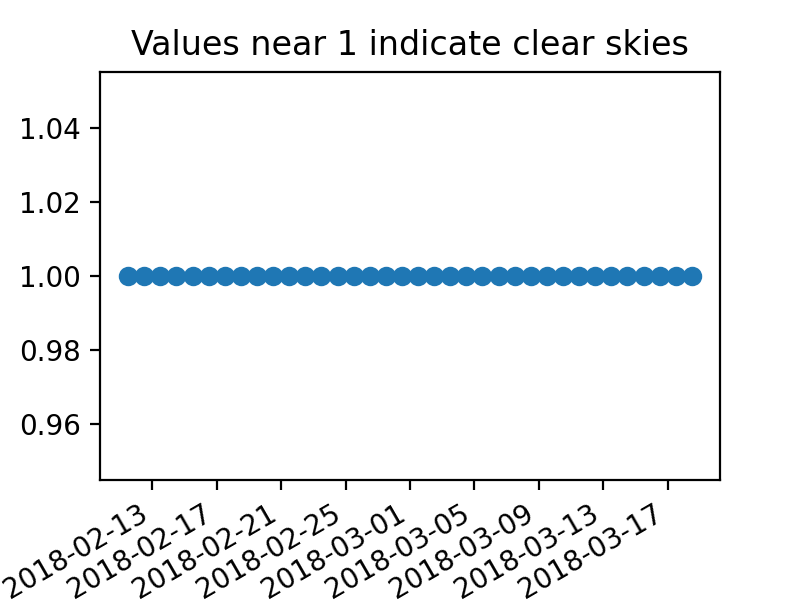

In [61]:
fig = plt.figure(figsize=(4,3),dpi=200)
plt.plot(good_data['time'],good_data,marker='o')
fig.autofmt_xdate()
plt.title('Values near 1 indicate clear skies')

# Export figure
if savefig:
    plt.savefig(__figdir__+'good_data_' + shortname + '.' +plotfiletype,**savefig_args)

In [62]:
good_times = good_data['time'].where(good_data>0.8,drop=True)
np.shape(good_times)

(36,)

In [42]:
good_times[-1].values

numpy.datetime64('2018-03-18T12:00:00.000000000')

In [63]:
def plot_criterion_box(ax,**kwargs):
    """ Add a box to plots to show what box was used for the criterion.
         
    Inputs
    - matplotlib.pyplot.plot kwargs

    Return
    - exit code (True if OK)
    """

    coord = [[x1,y1], [x1,y2], [x2,y2], [x2,y1]]
    coord.append(coord[0]) #repeat the first point to create a 'closed loop'

    xs, ys = zip(*coord) #create lists of x and y values

    if ax is None:
        ax = plt.gca()    
    # ax.plot(xs,ys,transform=ccrs.PlateCarree()) 
    ax.plot(xs,ys,**kwargs) 

    SF_lon=-(122+25/60)
    SF_lat= 37+47/60

    # mark a known place to help us geo-locate ourselves
    '''
    ax.plot(SF_lon, SF_lat, 'o', markersize=3, zorder=10, **kwargs)
    ax.text(SF_lon-5/60, SF_lat+5/60, 'San Francisco', fontsize=8, zorder=10, **kwargs)
    # ax.text(np.mean(xs)-.6, np.mean(ys)-.3, 'S-MODE ops area', fontsize=8, **kwargs)
    print(kwargs)
    '''

    return(xs,ys,ax)


## Choose a particular time


In [64]:
# Find the data near this time
d = good_times[5] # np.datetime64('2021-11-05T00:00:00Z')

In [65]:
ds2 = ds.sel(time=d,method='nearest')

In [47]:
ds2

<xarray.Dataset>
Dimensions:                 (lon: 12, lat: 12, uncertainty_components: 9,
                             iceflag_components: 3)
Coordinates:
  * lon                     (lon) float32 63.62 63.88 64.12 ... 66.12 66.38
  * lat                     (lat) float32 13.62 13.88 14.12 ... 16.12 16.38
    time                    datetime64[ns] 2018-02-16T12:00:00
Dimensions without coordinates: uncertainty_components, iceflag_components
Data variables: (12/19)
    nobs                    (lat, lon) float64 dask.array<chunksize=(12, 12), meta=np.ndarray>
    nobs_RF                 (lat, lon) float64 dask.array<chunksize=(12, 12), meta=np.ndarray>
    nobs_40km               (lat, lon) float64 dask.array<chunksize=(12, 12), meta=np.ndarray>
    sss_smap                (lat, lon) float32 dask.array<chunksize=(12, 12), meta=np.ndarray>
    sss_smap_RF             (lat, lon) float32 dask.array<chunksize=(12, 12), meta=np.ndarray>
    sss_smap_unc            (lat, lon) float32 dask.array<chunksize=(12, 12), meta=np.ndarray>
    ...                      ...
    fland                   (lat, lon) float32 dask.array<chunksize=(12, 12), meta=np.ndarray>
    gice_est                (lat, lon) float32 dask.array<chunksize=(12, 12), meta=np.ndarray>
    surtep                  (lat, lon) float32 dask.array<chunksize=(12, 12), meta=np.ndarray>
    winspd                  (lat, lon) float32 dask.array<chunksize=(12, 12), meta=np.ndarray>
    sea_ice_zones           (lat, lon) int8 dask.array<chunksize=(12, 12), meta=np.ndarray>
    anc_sea_ice_flag        (lat, lon, iceflag_components) int8 dask.array<chunksize=(12, 12, 3), meta=np.ndarray>
Attributes: (12/65)
    Conventions:                                            CF-1.7, ACDD-1.3
    title:                                                  SMAP ocean surfac...
    version:                                                V5.0 Validated Re...
    summary:                                                The dataset conta...
    acknowledgement:                                        Funded under Subc...
    processing_level:                                       L3
    ...                                                     ...
    Source_of_SMAP_SSS_retrievals:                          T. Meissner, F. W...
    Source_of_ancillary_SST:                                Canada Meteorolog...
    Source_of_ancillary_CCMP_wind_speed:                    Mears, C. et al.,...
    Source_of_ancillary_AMSR2_sea_ice_flag_and_correction:  Meissner, T. and ...
    Source_of_ancillary_land_mask:                          1 km land/water m...
    Source_of_ancillary_reference_SSS_from_HYCOM:           Hybrid Coordinate...

In [66]:
# This string of the time of the SST selected will be useful
day_str = np.datetime_as_string(ds2.time,unit='m')

In [67]:
ds2.sss_smap[1][1].values

array(35.247204, dtype=float32)

((64.5, 64.5, 65.5, 65.5, 64.5),
 (14.5, 15.5, 15.5, 14.5, 14.5),
 <AxesSubplot: title={'center': 'SSS, 2018-02-16T12:00'}>)

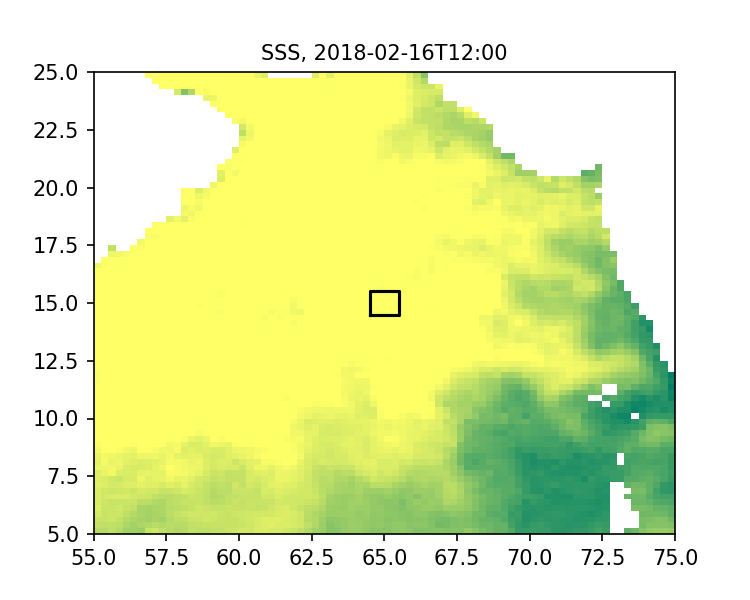

In [76]:
fig = plt.figure()
ax = plt.gca()
plt.set_cmap(cmap=plt.get_cmap('summer'))
ax.set_title('SSS, ' + day_str, size = 10.)
V=np.array([33,36])#np.array([25.5,26.5])+-3.75
cs = plt.pcolormesh(ds2.lon,ds2.lat,ds2.sss_smap.squeeze(),vmin=V[0],vmax=V[1])
plot_criterion_box(ax,color='k')

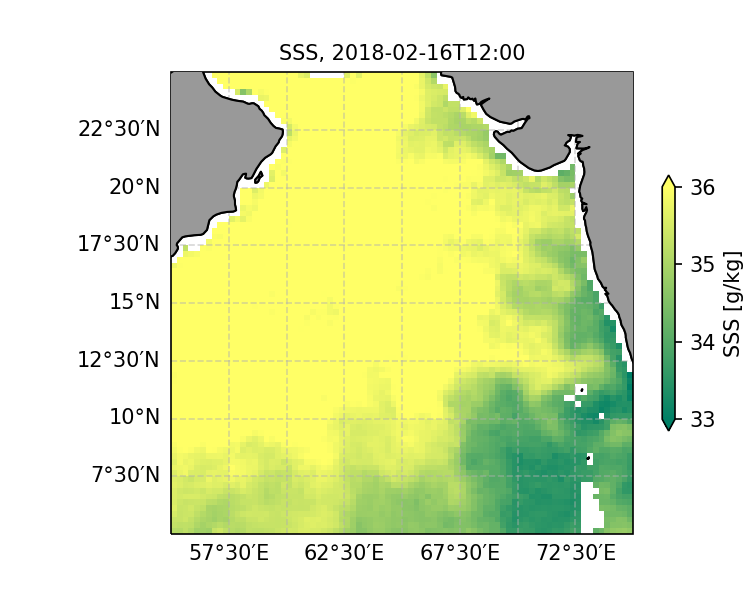

In [77]:
fig = plt.figure()
ax = plt.axes(projection = ccrs.PlateCarree(central_longitude=65))  # Orthographic
extent = [lon_min, lon_max,lat_min, lat_max]
ax.set_extent(extent, crs=ccrs.PlateCarree())
plot_criterion_box(ax,color='k')

plt.set_cmap(cmap=plt.get_cmap('summer'))
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
ax.set_title('SSS, ' + day_str, size = 10.)

# Does not do what I think it should:
ax.minorticks_on()
ax.tick_params(axis='both',which='both',direction='inout',top=True, right=True)


ax.coastlines()
ax.add_feature(cartopy.feature.LAND, zorder=3, facecolor=[.6,.6,.6], edgecolor='black')
cs = ax.pcolormesh(ds2.lon,ds2.lat,ds2.sss_smap.squeeze(),vmin=V[0],vmax=V[1],transform=ccrs.PlateCarree())
# cs = ax.pcolormesh(ds2.lon,ds2.lat,ds2.sea_surface_temperature.squeeze().notnull(),transform=ccrs.PlateCarree())
cb = plt.colorbar(cs,fraction = 0.022,extend='both')
cb.set_label('SSS [g/kg]',fontsize = 10)


# Export figure
if savefig:
    plt.savefig(__figdir__+'good_data_' + shortname + '.' +plotfiletype,**savefig_args)

# Next steps for this script and S-MODE processing

Features wanted:
1. Loop through good images and plot.  
2. Save images.  
3. Extract subset of good data and save as netcdf.  


In [1]:
# Extract a data set with only "good times"

good_times = good_data['time'].where(good_data>0.5,drop=True)
print(np.shape(good_times))

NameError: name 'good_data' is not defined

In [36]:
d = good_times # np.datetime64('2021-11-05T00:00:00Z')
ds2 = ds.sel(time=d,method='nearest')

In [37]:
ds2

<xarray.Dataset>
Dimensions:                  (lon: 250, lat: 150, time: 20)
Coordinates:
  * lon                      (lon) float32 -127.0 -127.0 ... -122.0 -122.0
  * lat                      (lat) float32 38.49 38.47 38.45 ... 35.53 35.51
  * time                     (time) datetime64[ns] 2022-10-21T20:30:01 ... 20...
Data variables:
    quality_level            (time, lat, lon) float32 dask.array<chunksize=(1, 150, 250), meta=np.ndarray>
    l2p_flags                (time, lat, lon) int16 dask.array<chunksize=(1, 150, 250), meta=np.ndarray>
    or_number_of_pixels      (time, lat, lon) float32 dask.array<chunksize=(1, 150, 250), meta=np.ndarray>
    sea_surface_temperature  (time, lat, lon) float32 dask.array<chunksize=(1, 150, 250), meta=np.ndarray>
    sses_standard_deviation  (time, lat, lon) float32 dask.array<chunksize=(1, 150, 250), meta=np.ndarray>
    sst_dtime                (time, lat, lon) timedelta64[ns] dask.array<chunksize=(1, 150, 250), meta=np.ndarray>
    crs                      (time) int32 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0
    sst_gradient_magnitude   (time, lat, lon) float32 dask.array<chunksize=(1, 150, 250), meta=np.ndarray>
    sst_front_position       (time, lat, lon) float32 dask.array<chunksize=(1, 150, 250), meta=np.ndarray>
Attributes: (12/58)
    Conventions:                Conventions = CF-1.7, ACDD-1.3
    acknowledgement:            Please acknowledge the use of these data with...
    cdm_data_type:              grid
    comment:                    SSTs are a weighted average of the SSTs of co...
    creator_email:              Alex.Ignatov@noaa.gov
    creator_name:               Alex Ignatov
    ...                         ...
    col_start:                  2857
    col_count:                  2786
    l3u_bias_subskin_night:     0.034
    l3u_bias_subskin_day:       0.018
    l3u_bias_depth_night:       0.01
    l3u_bias_depth_day:         0.012

In [ ]:
# Write the subsetted data set to a netcdf file
#ds2.to_netcdf('outfile.nc',format="NETCDF4")